# Machine Learning Engineer Nanodegree

### Capstone Project: Starbucks’ Capstone Challenge - Notebook 3.

***Maria Balog  
May 18th, 2020***

### Recap

This project is broken down into a number of notebooks to facilitate ease of testing and trouble-shooting. This is the third notebook of this project, for a full description of the problem, please refer to the first notebook [*here*](Starbucks_Capstone_notebook.ipynb).

In brief, we have a month worth of data for about 15,000 users who may or may not have acted upon digital offers received from Starbucks. 

### Problem Statement

Our main areas of query are, for what demographic groups and what offer types  
- are offers most likely to be viewed within their valid duration?
- are offers most likely to be completed, given that they were viewed?
- can we find a correlation between an offer being viewed and the total amount of transactions within the duration of the offer?


## Implementation

The implementation of the solution consists of the following steps:
- data cleaning and visualization (see [*Notebook 1.*](Starbucks_Capstone_notebook.ipynb))
- feature engineering (see [*Notebook 2.*](Starbucks_Capstone_notebook.ipynb))
- applying KMeans clustering to examine viewing rates
- applying KMeans clustering to examine completion rates
- applying KMeans clustering to examine total transaction amounts
- final evaluation and conclusions

In this notebook, we will focus on the fourth step: **applying KMeans clustering to examine viewing rates**. 

To that end, we will examine the combination of the `offer_received` and `offer_viewed` datasets, joined with the `portfolio` and `profile` datasets to add details on the demographic and offer type data.

We have already created this dataset in our previous notebook, so let's load it in!

In [1]:
import pandas as pd
import numpy as np
import math

dtype_ovp  = {'age': np.int8,  'male': np.int8,  'female': np.int8,  'other': np.int8 ,
              'member_days': np.int16,  'reward': np.int8,  'difficulty': np.int8,
              'duration': np.int16,  'web': np.int8,  'mobile': np.int8,  'social': np.int8,
              'bogo': np.int8,  'info': np.int8,  'disc': np.int8,  'is_viewed': np.int8 } 
offer_viewed_profile = pd.read_csv('data/offer_viewed_profile.csv', dtype=dtype_ovp)
offer_viewed_profile.tail()

,age,income,member_days,female,male,other,reward,difficulty,duration,web,mobile,social,bogo,info,disc,is_viewed
66496,83,50000.0,957,1,0,0,10,10,7,0,1,1,1,0,0,1
66497,62,82000.0,455,1,0,0,5,5,5,1,1,1,1,0,0,0
66498,62,82000.0,455,1,0,0,3,7,7,1,1,1,0,0,1,1
66499,62,82000.0,455,1,0,0,0,0,4,1,1,0,0,1,0,0
66500,62,82000.0,455,1,0,0,0,0,4,1,1,0,0,1,0,0


Again, this is the combination of the demographic data and the properties of the offers that were received and possibly viewed by each user.

Implementing KMeans clustering and interpreting the data requires the following steps:
- standardization 
- principal component analysis (PCA)
- determining the optimal K value(s)
- performing KMeans clustering
- reversing PCA and standardization on the cluster centers
- interpreting the results

### Standardization

First we need to standardize the data, so that each column's mean is `0` and their standard deviation is `1`.

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
scaled_ovp = pd.DataFrame(scaler.fit_transform(offer_viewed_profile.astype(float)))
scaled_ovp.columns = offer_viewed_profile.columns
scaled_ovp.describe().round(4)

,age,income,member_days,female,male,other,reward,difficulty,duration,web,mobile,social,bogo,info,disc,is_viewed
count,66501.0000,66501.0000,66501.0000,66501.0000,66501.0000,66501.0000,66501.0000,66501.0000,66501.0000,66501.0000,66501.0000,66501.000,66501.0000,66501.0,66501.0000,66501.0000
mean,-0.0000,-0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,0.0000,-0.000,-0.0000,0.0,0.0000,-0.0000
std,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.000,1.0000,1.0,1.0000,1.0000
min,-2.0908,-1.6358,-1.2450,-0.8386,-1.1593,-0.1182,-1.2356,-1.3906,-1.5912,-1.9976,-2.9811,-1.221,-0.8149,-0.5,-0.8181,-1.6815
25%,-0.7111,-0.7571,-0.7488,-0.8386,-1.1593,-0.1182,-0.6471,-0.4893,-0.6839,0.5006,0.3354,-1.221,-0.8149,-0.5,-0.8181,-1.6815
50%,0.0363,-0.0634,-0.3910,-0.8386,0.8626,-0.1182,0.2358,0.4120,0.2234,0.5006,0.3354,0.819,-0.8149,-0.5,-0.8181,0.5947
75%,0.6686,0.6765,0.6586,1.1925,0.8626,-0.1182,0.2358,0.4120,0.2234,0.5006,0.3354,0.819,1.2272,-0.5,1.2223,0.5947
max,2.6807,2.5264,3.1037,1.1925,0.8626,8.4616,1.7072,2.2147,1.5843,0.5006,0.3354,0.819,1.2272,2.0,1.2223,0.5947


### Principal Component Analysis for Dimentionality Reduction

Next, we can examine the principal components of this dataset. Although strictly speaking, for sixteen input features it is not necessary to perform PCA for dimensionality reduction, we will apply it anyway for efficiency's sake. 

In [3]:
# first set PCA components to the number of features -1
pca = PCA(n_components=15)
pca.fit(scaled_ovp)

print('Eigenvalues: \n', pca.singular_values_.round(2))
print('\nExplained Variance: \n', pca.explained_variance_.round(3))

explained_vr = pca.explained_variance_ratio_.round(4)
print('\nExplained Variance Ratio: \n', explained_vr)

Eigenvalues: 
 [499.78 421.18 377.68 303.75 276.29 263.44 261.49 256.75 213.95 192.46
 147.34 102.61  76.18  32.35   0.  ]

Explained Variance: 
 [3.756 2.668 2.145 1.387 1.148 1.044 1.028 0.991 0.688 0.557 0.326 0.158
 0.087 0.016 0.   ]

Explained Variance Ratio: 
 [0.2348 0.1667 0.1341 0.0867 0.0717 0.0652 0.0643 0.062  0.043  0.0348
 0.0204 0.0099 0.0055 0.001  0.    ]


#### *Figuring out how many principal components to keep*

In [4]:
# cheking the sums of the explained variance for the first ii components
for ii in range(1,15):
    print('Variance percentage with {} components: {}%'.format(ii, (explained_vr[:ii].sum()*100).round(2)))

Variance percentage with 1 components: 23.48%
Variance percentage with 2 components: 40.15%
Variance percentage with 3 components: 53.56%
Variance percentage with 4 components: 62.23%
Variance percentage with 5 components: 69.4%
Variance percentage with 6 components: 75.92%
Variance percentage with 7 components: 82.35%
Variance percentage with 8 components: 88.55%
Variance percentage with 9 components: 92.85%
Variance percentage with 10 components: 96.33%
Variance percentage with 11 components: 98.37%
Variance percentage with 12 components: 99.36%
Variance percentage with 13 components: 99.91%
Variance percentage with 14 components: 100.01%


This means that by keeping the first ten components, we can retain over 95% of variability of the data. 

#### *Visualizing the top ten principal components*

Below is a visual representation of the composition of the first ten components (here I use absolute values because I am only interested in the weight of the columns in each component).

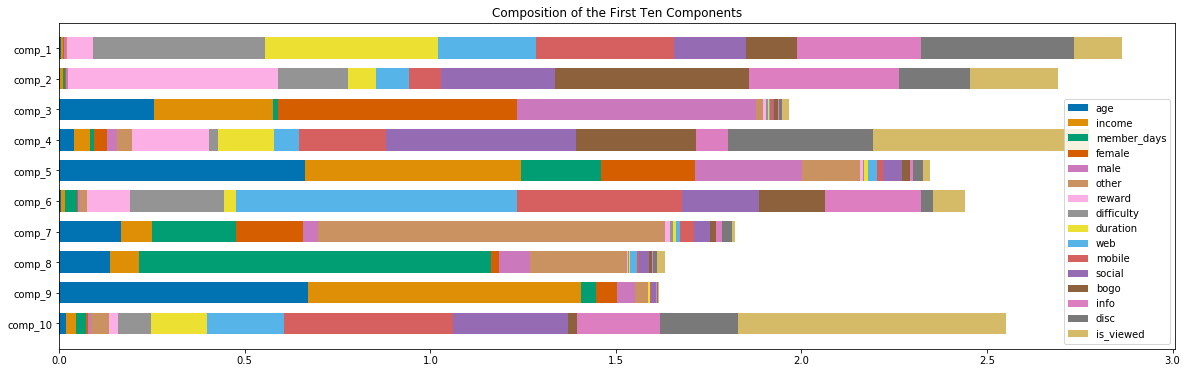

In [5]:
import sys  
sys.path.insert(0, './source')
        
import sb_data_visualization as dv
import sb_modeling as modeling

%matplotlib inline

# convert the array of principal components to a dataframe
data = pd.DataFrame(np.abs(pca.components_[:10]))

rows = ['comp_'+str(ii) for ii in range(1, 11)]
columns = offer_viewed_profile.columns

data.index = rows    
data.columns = columns

dv.display_principal_components(data)

So keeping ten principal components and retaining 95% variability of the data seems reasonable. 

In [6]:
# keep however many components result in retaining 95% variability
pca2 = PCA(.95)
pca2.fit(scaled_ovp)

explained_vr = pca2.explained_variance_ratio_.round(4)
print('\nExplained Variance Ratio: \n', explained_vr)

# generate row names for indexing the df
trans_data = pd.DataFrame(pca2.transform(scaled_ovp), columns=rows)
trans_data.head().round(2)


Explained Variance Ratio: 
 [0.2348 0.1667 0.1341 0.0867 0.0717 0.0652 0.0643 0.062  0.043  0.0348]


,comp_1,comp_2,comp_3,comp_4,comp_5,comp_6,comp_7,comp_8,comp_9,comp_10
0,-0.01,-0.30,2.17,2.23,-0.73,-1.05,0.04,-0.39,-1.46,0.92
1,-1.72,2.88,2.20,1.66,-0.70,-0.48,0.03,-0.39,-1.47,0.32
2,-0.30,-0.83,2.32,0.88,-1.17,-1.23,0.16,-0.30,-0.28,-0.72
3,-1.12,-1.39,2.31,-0.03,-1.07,-0.84,0.08,-0.36,-0.26,-0.22
4,-0.84,-2.69,2.30,0.00,-1.01,1.48,0.12,-0.42,-0.25,0.32


Now let's move on to fitting our clustering algorithms.

### Determining the Optimal Number of Clusters

First, let's try to use the elbow method to figure out the optimal number of clusters. Since we have ten types of promotions, I'm hoping we would have a number of clusters close to that.

To determine the optimal `k` value, we will use three diiferent metrics:
- within-cluster sum-of-squares criterion
- Calinski-Harabasz score
- Davies-Bouldin index

The inertia, or within-cluster sum-of-squares criterion is a measure of how internally coherent clusters are. ***Lower values are better and zero is optimal.***

If the ground truth labels are not known, the Calinski-Harabasz index (also known as the Variance Ratio Criterion) can be used to evaluate the model, where ***a higher Calinski-Harabasz score relates to a model with better defined clusters***. This score is the ratio of the sum of between-clusters dispersion and of inter-cluster dispersion for all clusters (where dispersion is defined as the sum of distances squared).

The Davies-Bouldin index signifies the average ‘similarity’ between clusters, where the similarity is a measure that compares the distance between clusters with the size of the clusters themselves. ***A lower Davies-Bouldin index relates to a model with better separation between the clusters.*** Zero is the lowest possible score. 

Wall time: 1min 6s


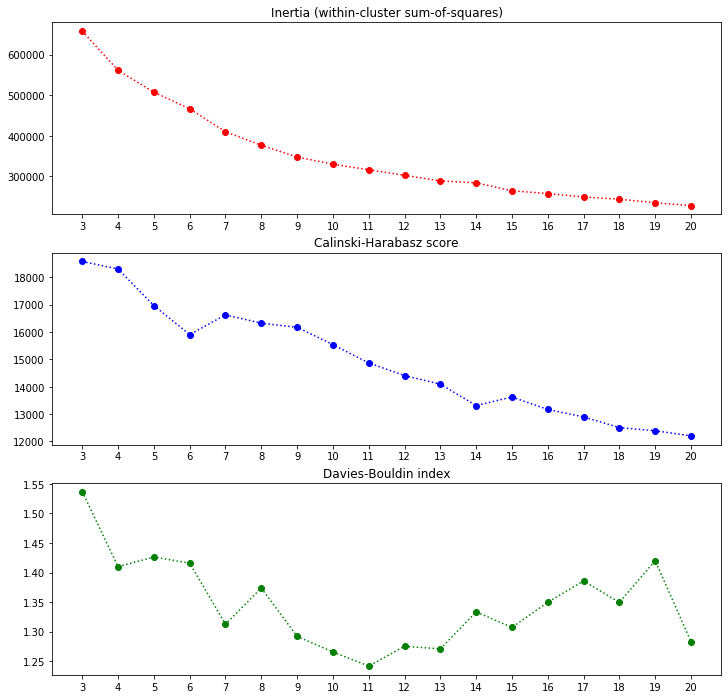

In [7]:
%%time

modeling.init_metrics(trans_data)
modeling.display_metrics()

To interpret the above three charts, the first one is plotting the inertia, and is often used to perform the "elbow method", i.e. finding a point where the slope of the curve suddenly changes, typically becomes less negative or even turns positive. Unfortunately our curvedoes not have any pronounced "elbows".  

In the second chart, higher values indicate better defined clusters, so ideally we are looking for local maximums, such as `k=7` or `k=13`. Values in the third chart indicate the average ‘similarity’ between clusters, and this time the ideal values are the local minima, such as `k=7`, `k=11`, `k=13` or `k=15`. Based on these two charts, `k=13` is the best candidate.


Another thing we can examine is the number of datapoints falling in each cluster for a range of `k` values. To that end, we can visualize the cluster sizes in various ways for `k` values ranging from 3 to 20, see if we can discover any trends.

In [8]:
%%time 

n = 21
results = pd.DataFrame(index=range(n-1))
for ii in range(3, n):
    results['count'+str(ii)] = modeling.get_cluster_counts(trans_data, n, ii)


Wall time: 1min 7s


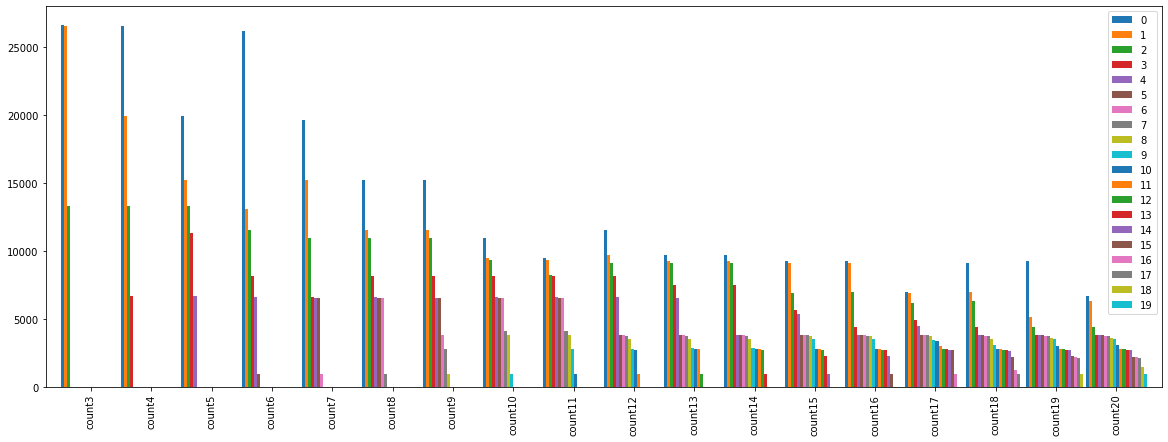

In [9]:
ax = results.transpose().plot.bar(figsize=(20, 7), width=1);

The clusters for each `k` value are relatively close in size, which is usually a good sign. We can also notice that some of the cluster sizes remain the same as we increase the number of cluster centers, which means those clusters are not easily broken up or reorganized into smaller clusters. Below is a more precise representation of these trends.

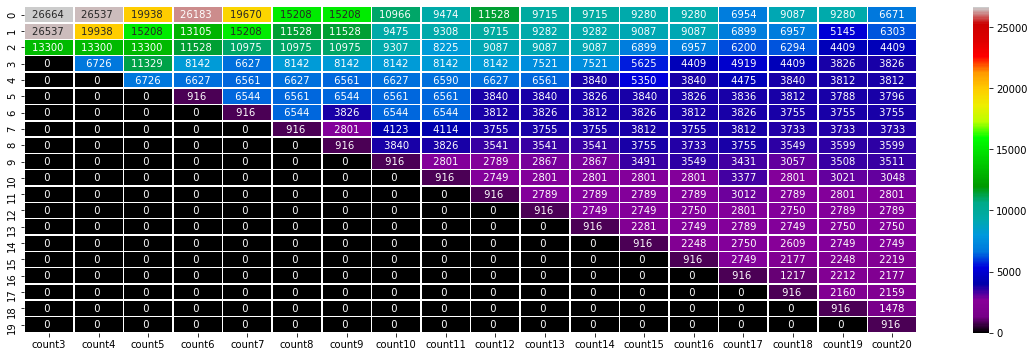

In [10]:
dv.display_cluster_sizes(results)

The most obvious example is the smallest cluster (size 916), that remains stable from `k=6` all the way to `k=20` (and probably beyond), or the cluster sized 2749 and 2801, that carries over from `k=12` to `k=20` . Other great examples of stable clusters are clusters sized 2789, 3812, 3826 and 3840. Of course these trends slightly vary depending on the random seed, I have run it for 0, 1, 2 and 3 as well, and got very similar results.

The above charts also confirm that `k=13` is an optimal `k` value.



### Performing KMeans Clustering and Reversing PCA and Standardization on the Cluster Centers

If we run KMeans clustering for `k=13`, in this case we will get 14 ten-dimensional centroids, that can be considered representative datapoints for our entire dataset. However, to interpret them, we still need to consider how PCA and standardization affected the original features.

In [11]:
%%time

from sklearn.cluster import KMeans

# set the number of iterations within the algorithm a little higher
km13 = KMeans(n_clusters=13, n_init=20, max_iter=500, random_state=42)
km13 = km13.fit(trans_data)


Wall time: 7.35 s


In order to recover the original feature values for each centroid, we can to use the `PCA.inverse_transform()` method, to get our 14-dimentional datapoints, then call `StandardScaler.inverse_transform()` to scale bac to the original values.

In [12]:
pca2_inverse = pca2.inverse_transform(km13.cluster_centers_)
scaled_df = pd.DataFrame(pca2_inverse, columns=columns)
scaled_df.describe().round(2)

,age,income,member_days,female,male,other,reward,difficulty,duration,web,mobile,social,bogo,info,disc,is_viewed
count,13.00,13.00,13.00,13.00,13.00,13.00,13.00,13.00,13.00,13.00,13.00,13.00,13.00,13.00,13.00,13.00
mean,-0.00,-0.02,-0.01,-0.04,-0.09,0.54,-0.10,0.07,0.04,0.03,-0.22,-0.27,-0.12,0.11,0.03,-0.27
std,0.14,0.20,0.05,0.91,0.93,2.38,0.98,1.17,1.04,0.86,1.15,0.95,0.93,1.02,0.98,0.85
min,-0.15,-0.20,-0.12,-0.84,-1.16,-0.12,-1.47,-1.42,-1.47,-2.00,-2.80,-1.47,-0.90,-0.51,-0.85,-1.77
25%,-0.11,-0.16,-0.04,-0.84,-1.16,-0.12,-0.72,-0.23,-0.35,-0.04,0.00,-1.27,-0.80,-0.50,-0.81,-0.78
50%,-0.09,-0.15,-0.00,-0.12,0.14,-0.12,-0.05,0.01,-0.08,0.36,0.23,-0.06,-0.68,-0.48,-0.72,0.19
75%,0.18,0.24,0.02,1.19,0.86,-0.11,0.52,0.22,0.72,0.54,0.34,0.47,1.06,0.03,1.21,0.46
max,0.19,0.29,0.04,1.19,0.86,8.46,1.62,2.24,1.67,0.72,0.48,1.31,1.25,2.12,1.25,0.67


If we look at the standardized values of the centroids, the standard deviation seems to be the greatest for the `gender`, `reward`, `difficulty`, `duration`, `channel` and `offer type` columns, so we expect these columns to determine how various demographic groups respond to various offers, which is the answer to our first main question concerning viewing rates. 

In [13]:
scaler_inverse = scaler.inverse_transform(pca2_inverse)
centroid_df = pd.DataFrame(scaler_inverse, columns=columns)
centroid_df.describe().round(2)

,age,income,member_days,female,male,other,reward,difficulty,duration,web,mobile,social,bogo,info,disc,is_viewed
count,13.00,13.00,13.00,13.00,13.00,13.00,13.00,13.00,13.00,13.00,13.00,13.00,13.00,13.00,13.00,13.00
mean,54.29,65026.66,602.84,0.40,0.53,0.08,3.88,8.10,6.59,0.81,0.83,0.47,0.34,0.24,0.42,0.62
std,2.43,4352.89,19.10,0.45,0.46,0.28,3.33,6.49,2.28,0.35,0.35,0.47,0.46,0.41,0.48,0.37
min,51.71,61070.32,559.66,-0.00,-0.00,-0.00,-0.80,-0.17,3.27,0.00,0.06,-0.12,-0.04,-0.00,-0.02,-0.04
25%,52.46,61867.21,591.67,0.00,0.00,-0.00,1.76,6.46,5.73,0.78,0.90,-0.02,0.01,-0.00,0.01,0.39
50%,52.76,62201.76,605.91,0.36,0.64,-0.00,4.05,7.77,6.33,0.94,0.97,0.57,0.07,0.01,0.05,0.82
75%,57.42,70561.08,616.20,1.00,1.00,0.00,5.98,8.93,8.09,1.02,1.00,0.83,0.92,0.21,0.99,0.94
max,57.63,71618.44,624.76,1.00,1.00,1.00,9.72,20.16,10.19,1.09,1.04,1.24,1.01,1.05,1.02,1.03


In [14]:
df = centroid_df.corr().round(2)
df[['is_viewed']].style.background_gradient(cmap='Blues')

,is_viewed
age,0.24
income,0.25
member_days,0.32
female,-0.03
male,-0.08
other,0.18
reward,0.18
difficulty,-0.15
duration,-0.17
web,-0.37


If we look at correlation between individual columns and the `is_viewed` flag, we find the highest score for the `social` column (not unexpectedly), there is also a slight correlation with the `mobile`, as well as the `member_days`, `income` and `age` columns.

Let's reverse some of the previously performed one-hot encoding for `gender` and `offer_type` to get an even clearer picture.

In [15]:

results_df = pd.DataFrame(centroid_df) 

res = km13.labels_
ccounts = pd.DataFrame(res, columns=['clusters'])
ccounts = ccounts.groupby('clusters').size()
ccounts = ccounts.reset_index(name='count')
results_df['count'] = ccounts['count']

gender = centroid_df[['female', 'male', 'other']].idxmax(1)
results_df['gender'] = gender
results_df.drop(columns=['female', 'male', 'other'], inplace=True)


In [16]:
offer_type = centroid_df[['bogo', 'info', 'disc']].round().idxmax(1)

results_df['offer_type'] = offer_type
results_df.drop(columns=['bogo', 'info', 'disc'], inplace=True)
# drop columns with relatively small variance -- actually, there seems to be some correlation, so keep them.
results_df.drop(columns=['age', 'income', 'member_days'], inplace=True)


In [17]:
results_df['web'] = results_df['web'].abs().round()
results_df['mobile'] = results_df['mobile'].abs().round()
results_df['social'] = results_df['social'].abs().round()

In [18]:
results_df.sort_values(by=[ 'gender', 'offer_type']).round(2)

,reward,difficulty,duration,web,mobile,social,is_viewed,count,gender,offer_type
1,7.87,7.77,5.91,1.0,1.0,1.0,0.94,9715,female,bogo
3,2.27,8.91,8.09,1.0,1.0,1.0,0.97,6899,female,disc
6,5.19,20.16,10.18,1.0,0.0,0.0,0.39,2801,female,disc
5,-0.80,-0.17,3.62,1.0,1.0,0.0,0.51,2749,female,info
2,7.16,6.77,5.73,1.0,1.0,1.0,1.03,9087,male,bogo
9,9.72,10.31,6.33,0.0,1.0,1.0,0.82,3840,male,bogo
11,5.98,6.46,6.03,1.0,1.0,0.0,-0.03,3541,male,bogo
0,1.76,8.56,8.01,1.0,1.0,0.0,-0.04,3491,male,disc
4,2.28,8.93,8.09,1.0,1.0,1.0,0.99,9280,male,disc
12,5.19,20.16,10.19,1.0,0.0,0.0,0.36,3826,male,disc


#### *Section Summary*

So what can we learn from this data?
- ladies are over 80% likely to view buy-one-get-one offers
- they are twice as likely to view discount offers if they receive it on their mobile phones and social media as well
- gentlemen are virtually certain to view a buy-one-get-one offer if they receive it on all channels, but extremely unlikely to view it if they don't receive it on social media 
- they are also extremely likely to view discount offers, if they receive them on all channels, but only about one out of three would view discounts they only receive via the web
- both ladies and gentlemen respond much better to 2 dollars discount on 10 dollars spending, compared to 5 dollars discount on 20 dollars spending
- both ladies and gentlemen are much less likely to view an informational promotion if they receive it via the web instead of social media
- finally, members with unspecified gender are 85% likely to view buy-one-get-one offers if they receive them through all channels  

Compared to other columns in the cluster center dataframe, there is very little variance in the `age`, `income` and `member_days` columns, which could mean that these factors have very little effect on whether or not an offer is viewed, but it could also be an artifact of the clustering algorithm, since these columns' distributions are much closer to normal distribution than the one-hot encoded columns.

### Increasing the Number of Clusters for a More Granual Breakdown

Let's see if we can increase the number of clusters for a more granual analysis.

Wall time: 2min 4s


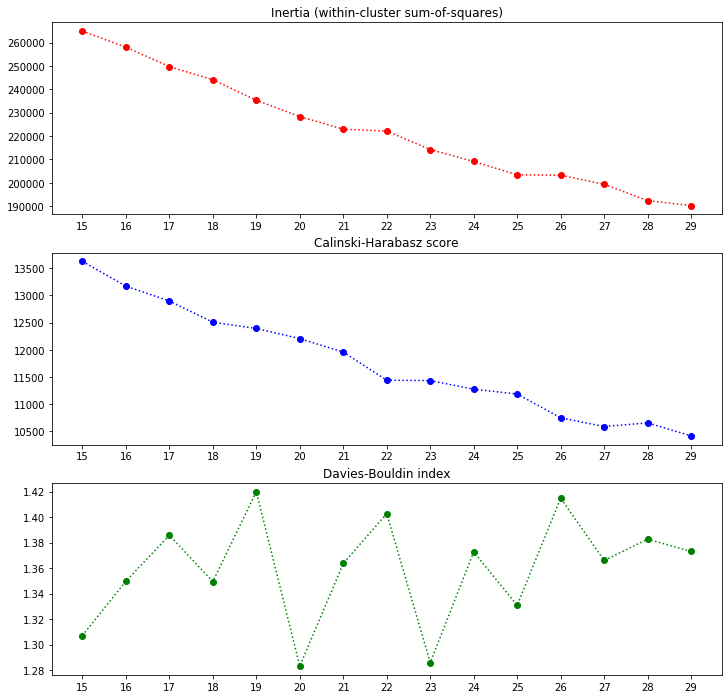

In [19]:
%%time

modeling.init_metrics(trans_data, k_min=15, k_max=30)
modeling.display_metrics(k_min=15, k_max=30)

To interpret the above three charts: the first one is plotting the inertia, and is often used to perform the "elbow method". Unfortunately our curve does not have any pronounced "elbows".   

In the second chart, higher values indicate better defined clusters, so ideally we are looking for local maxima, such as  `k=19` or `k=23`. Values in the third chart indicate the average ‘similarity’ between clusters, and this time the ideal values are the local minima, like  `k=20` or `k=23`. (**Note:** I have performed this analysis with several different random seeds, and some of them gave vastly different results.)

Another thing we can examine is the number of datapoints falling in each cluster for a range of `k` values. To that end, we can visualize the cluster sizes in various ways for `k` values ranging from 15 to 30, see if we can discover any trends.

Wall time: 2min 7s


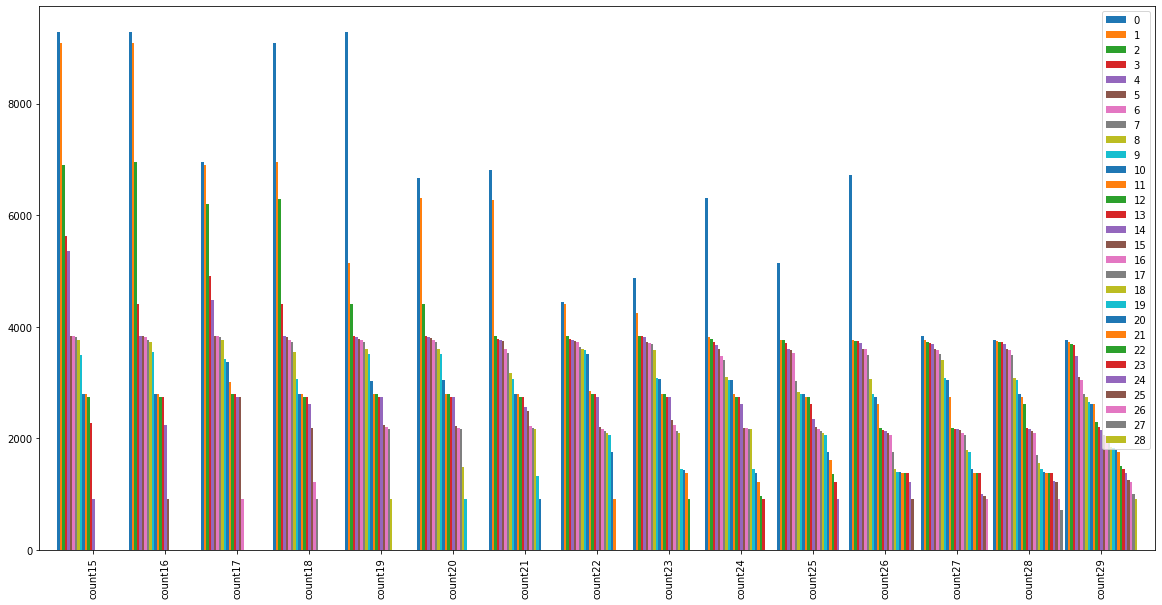

In [20]:
%%time 

n = 30
cluster_sizes_df = pd.DataFrame(index=range(n-1))
for ii in range(15, n):
    cluster_sizes_df['count'+str(ii)] = modeling.get_cluster_counts(trans_data, n, ii)

cluster_sizes_df.transpose().plot.bar(figsize=(20, 10), width=1);

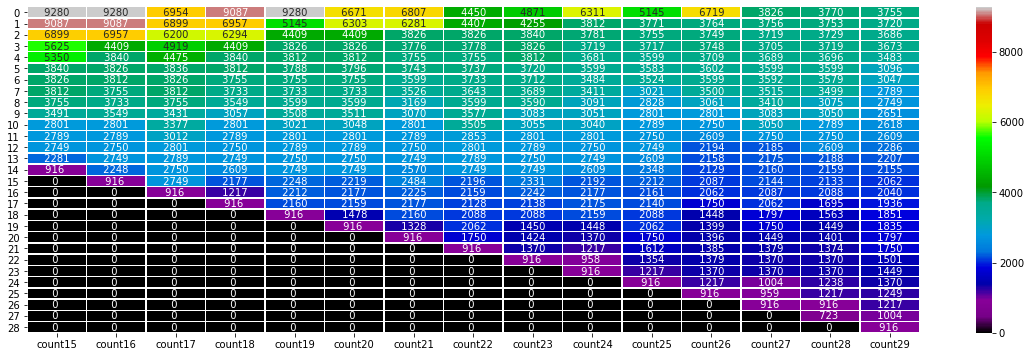

In [21]:
# a more precise representation using annotated heatmap
dv.display_cluster_sizes(cluster_sizes_df)

Based on the above two charts, `k=23` seems like an optimal choice, so below we repeat the same steps as above, namely:
- creating 23 clusters
- reversing the PCA transform for the 23 centroids
- reversing the standard scaling for the 23 centroids
- adding the datapoint count for each cluster
- reversing the one-hot encoding for `gender` and `offer_type`
- rounding the `web`, `mobile`, and `social` flags for better readibility


In [22]:
%%time
# set the number of iterations within the algorithm a little higher
km23 = KMeans(n_clusters=23, n_init=20, max_iter=500, random_state=42)
km23 = km23.fit(trans_data)

Wall time: 17.8 s


In [23]:
pca2_inverse23 = pca2.inverse_transform(km23.cluster_centers_)
scaled_df23 = pd.DataFrame(pca2_inverse23, columns=columns)
scaled_df23.describe().round(2)

,age,income,member_days,female,male,other,reward,difficulty,duration,web,mobile,social,bogo,info,disc,is_viewed
count,23.00,23.00,23.00,23.00,23.00,23.00,23.00,23.00,23.00,23.00,23.00,23.00,23.00,23.00,23.00,23.00
mean,-0.00,-0.01,0.04,0.04,-0.10,0.26,-0.09,-0.06,-0.03,-0.05,0.03,-0.04,-0.08,0.08,0.01,-0.15
std,0.42,0.48,0.48,1.03,1.03,1.79,0.94,0.97,0.94,0.99,0.90,0.86,0.96,1.03,0.97,0.88
min,-0.84,-0.73,-0.59,-0.84,-1.16,-0.12,-1.47,-1.42,-1.49,-2.02,-2.80,-1.47,-0.90,-0.53,-0.85,-1.76
25%,-0.26,-0.40,-0.09,-0.84,-1.16,-0.12,-0.71,-0.22,-0.35,0.14,0.10,-0.77,-0.80,-0.50,-0.81,-0.70
50%,0.02,-0.10,-0.03,-0.84,0.86,-0.12,-0.55,-0.02,-0.08,0.37,0.28,0.16,-0.73,-0.48,-0.72,0.19
75%,0.19,0.28,0.03,1.19,0.86,-0.12,0.70,0.22,0.71,0.56,0.44,0.51,1.14,-0.15,1.20,0.56
max,0.68,0.97,1.73,1.19,0.86,8.46,1.62,2.24,1.67,0.72,0.48,1.31,1.25,2.13,1.25,0.68


In [24]:
scaler_inverse23 = scaler.inverse_transform(pca2_inverse23)
centroid_df23 = pd.DataFrame(scaler_inverse23, columns=columns)
centroid_df23.describe().round(2)

,age,income,member_days,female,male,other,reward,difficulty,duration,web,mobile,social,bogo,info,disc,is_viewed
count,23.00,23.00,23.00,23.00,23.00,23.00,23.00,23.00,23.00,23.00,23.00,23.00,23.00,23.00,23.00,23.00
mean,54.33,65238.78,622.59,0.43,0.52,0.04,3.89,7.39,6.44,0.78,0.91,0.58,0.36,0.23,0.41,0.67
std,7.32,10433.33,199.18,0.51,0.51,0.21,3.19,5.39,2.08,0.40,0.27,0.42,0.47,0.41,0.48,0.39
min,39.70,49689.91,358.59,-0.00,-0.00,-0.00,-0.80,-0.17,3.23,-0.01,0.06,-0.12,-0.04,-0.01,-0.02,-0.04
25%,49.86,56821.43,570.39,-0.00,0.00,-0.00,1.77,6.47,5.73,0.86,0.93,0.22,0.01,0.00,0.01,0.43
50%,54.73,63155.38,594.24,0.00,1.00,0.00,2.33,7.60,6.33,0.95,0.98,0.68,0.04,0.01,0.05,0.82
75%,57.68,71436.66,619.16,1.00,1.00,0.00,6.57,8.92,8.07,1.02,1.03,0.85,0.96,0.14,0.99,0.99
max,66.13,86321.60,1331.93,1.00,1.00,1.00,9.72,20.16,10.19,1.09,1.04,1.24,1.01,1.05,1.02,1.04


In [25]:

res = km23.labels_

ccounts = pd.DataFrame(res, columns=['clusters'])
ccounts = ccounts.groupby('clusters').size()
ccounts = ccounts.reset_index(name='count')

results_df = pd.DataFrame(centroid_df23) 
results_df['count'] = ccounts['count']

In [26]:
gender = centroid_df23[['female', 'male', 'other']].idxmax(1)

results_df['gender'] = gender
results_df.drop(columns=['female', 'male', 'other'], inplace=True)

offer_type = centroid_df23[['bogo', 'info', 'disc']].round().idxmax(1)
results_df['offer_type'] = offer_type
results_df.drop(columns=['bogo', 'info', 'disc'], inplace=True)


In [27]:
results_df['web'] = results_df['web'].abs().round()
results_df['mobile'] = results_df['mobile'].abs().round()
results_df['social'] = results_df['social'].abs().round()

In [28]:
results_df.sort_values(by=['gender', 'offer_type']).round(2)

,age,income,member_days,reward,difficulty,duration,web,mobile,social,is_viewed,count,gender,offer_type
6,66.13,86181.68,607.70,7.15,6.79,5.74,1.0,1.0,1.0,1.03,3720,female,bogo
12,57.75,71040.37,601.78,9.71,10.30,6.34,0.0,1.0,1.0,0.78,2750,female,bogo
17,46.79,53361.58,581.11,7.10,6.73,5.72,1.0,1.0,1.0,1.02,3055,female,bogo
18,57.37,71556.12,610.16,6.07,6.48,6.04,1.0,1.0,0.0,-0.02,1450,female,bogo
3,57.61,70736.64,598.72,5.19,20.16,10.18,1.0,0.0,0.0,0.39,2801,female,disc
4,47.62,53539.70,585.50,2.27,8.91,8.07,1.0,1.0,1.0,0.98,3083,female,disc
13,65.73,86321.60,622.55,2.26,8.92,8.08,1.0,1.0,1.0,0.99,3689,female,disc
19,57.29,71317.20,590.63,1.78,8.56,8.02,1.0,1.0,0.0,-0.03,1370,female,disc
0,57.36,71668.53,594.24,0.51,-0.02,3.28,0.0,1.0,1.0,0.79,2789,female,info
16,57.42,70561.08,591.67,-0.80,-0.17,3.62,1.0,1.0,0.0,0.51,2749,female,info


#### *Section Summary*

According to this more granual breakdown, we found that:
- both ladies and gentlemen will almost certainly view buy-one-get-one offers, if they receive them on all channels, about 20% less likely to view them if they don't receive it via the web, and highly unlikely to view them if they don't receive them through social media
- we see a similar trend for both ladies and gentlemen viewing discount offers, they will almost certainly view them, if they receive them on all channels
- surprisingly, they are more likely to view "spend 20 dollars earn 5 dollars discount" offers they only receive through the web, compared to "spend 10 dollars earn 2 dollars discount" offers received both via the web and mobile phones
- as for info type offers, ladies are about 50%, while gentlemen are about 80% more likely to view them if they receive them via social media instead of the web
- finally, members with unspecified gender seem to be 85% likely to view buy-one-get-one offers if they get them through all channels (which is exactly the same as what we observed for 14 clusters) 


In [29]:
df = results_df.corr().round(2)
df[['is_viewed']].style.background_gradient(cmap='coolwarm')

,is_viewed
age,0
income,0.02
member_days,0.08
reward,0.12
difficulty,-0.13
duration,-0.16
web,-0.19
mobile,0.24
social,0.91
is_viewed,1


Examining the correlation between individual columns and the `is_viewed` flag, we can also confirm that there is no correlation between viewing trends and `age` or `income`, and very little correlation with the `difficulty`, `duration`, `reward` and `web` properties of the offers.

We can conclude that this more granual approach highlights viewing trends more accurately, and the most prominent factor proved to be receiving offers via social media vs. other channels.

Next, we examine trends in [**viewing and completing**](Starbucks_Capstone_notebook5.ipynb) offers.